# Lab 2: Localization of Wireless Cameras

### Important Notes:

-The xloc and yloc are all flipped in the data given to us

-Units are in inches.

-We need to localize 3 devices with the following MAC addresses:
    1. f8:cf:c5:97:e0:9e
    2. ec:d0:9f:db:e8:1f
    3. 80:e6:50:1b:a7:80
    4. Ground truth of device with MAC 44:91:60:d3:d6:94 is (-22, 162)
  Plan:
    1. We sort the all datasets into 4 sub-datasets for each MAC.
    2. The algorithm will use the log distance path loss model equation shown in detail in Lecture 7 Slides.
    3. Test the algorithm for the ground truth device.
    4. Extract location of other 3 devices.

In [1]:
import numpy as np, pandas as pd, json, os, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## 1. Take all datasets and sort them into 4 tables, one for each MAC address

In [2]:
cf = []
d0 = []
e6 = [] #initializaing empty arrays for each mac address
gt = [] #ground-truth device
desiredfiles = ['rss-1522970435.596356.txt', 'rss-1522970738.415368.txt','rss-1522970701.726474.txt',\
                'rss-1522970573.742740.txt','rss-1522970597.839427.txt','rss-1522970343.354430.txt',\
                'rss-1522970644.674140.txt','rss-1522970318.944313.txt','rss-1522982586.757204.txt',\
                'rss-1522982352.660042.txt','rss-1522982287.209725.txt','rss-1522982317.006285.txt',\
                'rss-1522982378.774766.txt','rss-1522982554.811150.txt','rss-1522982405.585248.txt',\
                'rss-1522982428.544539.txt','rss-1522982478.253961.txt']
for file in desiredfiles: #takes data from every file in folder
    filename = os.fsdecode(file)
    path = 'final_lab2_data/' + filename
    with open(path, 'r') as f:
        data = (json.loads(f.read().replace('\'','\"')))
    for x in range(0, len(data)):
        entry = data[x]
        if entry['mac'] == 'f8:cf:c5:97:e0:9e':
            cf.append({'loc_x': entry['loc_y'], 'loc_y': entry['loc_x'], 'rss': entry['rss']})
        elif entry['mac'] == 'ec:d0:9f:db:e8:1f':
            d0.append({'loc_x': entry['loc_y'], 'loc_y': entry['loc_x'], 'rss': entry['rss']})
        elif entry['mac'] == '80:e6:50:1b:a7:80':
            e6.append({'loc_x': entry['loc_y'], 'loc_y': entry['loc_x'], 'rss': entry['rss']})
        elif entry['mac'] == '44:91:60:d3:d6:94':
            gt.append({'loc_x': entry['loc_y'], 'loc_y': entry['loc_x'], 'rss': entry['rss']})
cfdf = pd.DataFrame(cf).apply(pd.to_numeric)
d0df = pd.DataFrame(d0).apply(pd.to_numeric)
e6df = pd.DataFrame(e6).apply(pd.to_numeric)
gtdf = pd.DataFrame(gt).apply(pd.to_numeric)

## 2. Finding missing parameters of log-distance path loss model

The log-distance path loss equation:

$P_{RX}[dBm]=C-\gamma*log(d(TX,RX))$

We will take the ground truth access point and calculate distance at every point in its trace. Then, we have only two missing variables, $C$ and $\gamma$, which we can find via linear regression.

In [3]:
distances = (-1*np.log(((-22-gtdf.loc_x)**2+(162-gtdf.loc_y)**2)**.5)).values.reshape(-1,1)
reg = LinearRegression()
reg.fit(distances,gtdf.rss)
gamma = reg.coef_[0]
C = reg.intercept_
print("gamma: {}\nC: {}".format(gamma,C))

gamma: 6.6308126377365815
C: -17.150464315366364


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


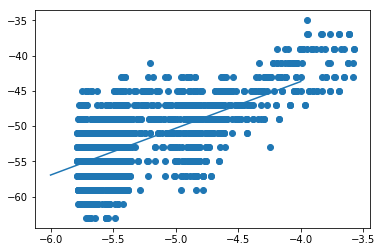

In [4]:
#plotting found regression against data
x = np.array(range(-6,-3))
plt.scatter(distances,gtdf.rss)
plt.plot(x,x*6.631-17.15)

## 3. Finding locations of access points with our complete model

Reformatting the log-distance path loss equation to find $TX$:

$$\gamma*log(d(TX,RX)) = C-P_{RX}[dBm]$$

$$d(TX,RX) = e^{(C-P_{RX}[dBm])/\gamma}$$

Given d(TX,RX) for separate coordinates RX1 and RX2, we can use the two resultant equations to find TX, i.e.:

$$d(TX,RX1) = \sqrt{(x_{TX}-x_{RX1})^{2}+(y_{TX}-y_{RX1})^{2}}$$ 

$$d(TX,RX2) = \sqrt{(x_{TX}-x_{RX2})^{2}+(y_{TX}-y_{RX2})^{2}}$$

$$x_{TX}^{2}-2(x_{TX}*x_{RX1})+x_{RX1}^{2}+y_{TX}^{2}-2(y_{TX}*y_{RX1})+y_{RX1}^{2} = d(TX,RX1)$$

$$x_{TX}^{2}-2(x_{TX}*x_{RX2})+x_{RX2}^{2}+y_{TX}^{2}-2(y_{TX}*y_{RX2})+y_{RX2}^{2} = d(TX,RX2)$$

multiplying the first equation by $y_{RX2}/y_{RX1}$, subtracting the two equations and letting $const = \frac{y_{RX2}}{y_{RX1}}*(x_{RX1}^{2}+y_{RX1}^{2})-x_{RX2}^{2}-y_{RX2}^{2}$:

$$(\frac{y_{RX2}}{y_{RX1}}-1)*x_{TX}^{2}-2x_{TX}(\frac{y_{RX2}}{y_{RX1}}*x_{RX1}-x_{RX2})-\frac{y_{RX2}}{y_{RX1}}*d(TX,RX1)+d(TX,RX2)+const = 0$$

from which $x_{TX}$ can be solved by using the quadratic formula $x = \frac{-b \pm \sqrt{b^{2}-4ac}}{2a}$

where $a=(\frac{y_{RX2}}{y_{RX1}}-1)$, $b=-2(\frac{y_{RX2}}{y_{RX1}}*x_{RX1}-x_{RX2})$, and $c=-\frac{y_{RX2}}{y_{RX1}}*d(TX,RX1)+d(TX,RX2)+const$

Then we can find $y_{TX}$ by plugging $x_{TX}$ into $d(TX,RX1)$:

$$y_{TX} = \sqrt{d(TX,RX1)^{2}-(x_{TX}-x_{RX1})^{2}}+y_{RX1}$$


### testing for correctness with ground truth

In [5]:
ds = np.exp((C-gtdf.rss)/gamma)
ds.describe()

count    2014.000000
mean      247.854848
std       171.730875
min        14.759807
25%       121.907529
50%       222.851830
75%       301.306876
max      1006.886212
Name: rss, dtype: float64

In [13]:
x1, x2, y1, y2 = gtdf.loc_x.iloc[0], gtdf.loc_x.iloc[-1], gtdf.loc_y.iloc[0], gtdf.loc_y.iloc[-1]
a, b, c = y2/y1-1, -2*(y2/y1*x1-x2), -y2/y1*ds.iloc[0]+ds.iloc[-1]+y2/y1*(x1**2+y1**2)-x2**2-y2**2
xt = ((-b-(b**2-4*a*c)**.5)/(2*a),(-b+(b**2-4*a*c)**.5)/(2*a))
print(xt)
#yt = (ds.iloc[0]**2 - (-22-x1)**2)**.5 + y1
#print("location of AP: ({},{})".format(xt,yt))

(7155.244476812265, 220.87855056958026)


In [7]:
gtdf.head()

,loc_x,loc_y,rss
0,169.952433,261.0,-57
1,169.962440,261.0,-57
2,172.089242,261.0,-57
3,172.099658,261.0,-57
4,174.117874,261.0,-57


In [8]:
pd.DataFrame(data).head()

,loc_x,loc_y,mac,rss,time
0,202.375167,289.0,44:91:60:d3:d6:94,-49,1.522982e+09
1,202.381476,289.0,f8:cf:c5:97:e0:9e,-47,1.522982e+09
2,203.747508,289.0,80:e6:50:1b:a7:80,-39,1.522982e+09
3,203.759333,289.0,80:e6:50:1b:a7:80,-39,1.522982e+09
4,203.776031,289.0,80:e6:50:1b:a7:80,-41,1.522982e+09
